<a href="https://colab.research.google.com/github/AthinaRA/AccSpark-PythonML_project/blob/main/ClassClust_BloodImmProteinMDD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Peripheral immune architecture in cases of depression**

*By: Athina Aruldass; Mentor: Chris Tegho 
(Accelerate Spark Data Science Residency | 15th April 2022)*

Although not a recognized immune-related disorder, depression is indeed linked to *low-grade chronic* peripheral inflammation. Typically (ie in clinical setting, immune state in humans is evaluated via blood immune cellular concentrations or a non-specific marker of inflammation (C-reactive protein; CRP), that are perhaps more reliable indicators of high-grade acute peripheral inflammation. Examining concentrations of smaller signalling blood immune proteins could provide a more accurate insight into peripheral immune landscape in cases of depression. 


This mini investigation seeks to:
1.   build a robust putative **CLASSIFIER** that would identify or predict depression cases with "healthier" general immune state (lower peripheral inflammation) vs "abnormal / less healthy" immune state (higher peripheral inflammation), given a set of small signalling blood immune proteins (N=26 features). *(labels or ground truth immune state were deduced from evaluation of CRP across two independent serological assesstments).*

2.  identify potential subtypes or **CLUSTERS** of depression cases based on peripheral immune profiles. 


Main sections in order (section breaks marked with ⚡ **HEADER**) :
*   Preprocessing: data preparation
*   Preprocessing: normalization & standardization
*   Data exploration: boxplot & density curves
*   Data exploration: ridgeline plot
*   Data exploration: correlation heatmap
*   Classification: building a base model
*   Classification: evaluating model performance
*   Classification: hyperparameter tuning & model optimization
*   Classification: comparing classifiers
*   Clustering: Gaussian mixture model
*   Clustering: (optional) data exploration - do GMM clusters accord with variation in PC scores ?
*   Clustering: determining optimal number of components for GMM
*   Clustering: Bayesian GMM
*   Clustering: exploring clusters from Bayesian GMM
*   Summary




In [ ]:
#Load libraries
import numpy as np
import pandas as pd
import seaborn as sb
from scipy import stats

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
#!conda install -c conda-forge xgboost

!pip install xgboost==1.4

In [2]:
#mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# change dir
# the base Google Drive directory
root_dir = "/content/drive/My Drive/"

# choose where you want your project files to be saved
project_folder = "Colab Notebooks/Spark_Cyto_Colab/"

# change the OS to use your project folder as the working directory
os.chdir(root_dir + project_folder)

In [4]:
# check current dir
!pwd

/content/drive/MyDrive/Colab Notebooks/Spark_Cyto_Colab


In [5]:
#Load data
df = pd.read_csv("./spark_prelog_cytoPLASMA.csv",header=0,sep=',')
#df.head()

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **PREPROCESSING: DATA PREP**

In [6]:
# rename cols with shorter names 
df.columns # to check col names
list(df.columns) # to get list names 

df.columns = ['Record.ID','Centre','Study.Arm','Sex','BMI','Age','crpGroup','CRP','Eotaxin','Eotaxin3',
 'GMCSF','IFNg','IL10','IL13','IL15','IL16','IL17','IL1b','IL2','IL4','IL5','IL6','IL7','IL8','IP10',
 'MCP1','MCP4','MDC','MIP1a','MIP1b','TARC','TNFa','TNFb','VEGF']


In [7]:
df.dtypes # float64 is numeric chr w decimals

# VEGF and Eotx are 'object' here - there are str "Complete" entries, not all numeric
#df.loc[:,'VEGF.plasma'] # use 'label' location

Record.ID      int64
Centre        object
Study.Arm     object
Sex           object
BMI           object
Age          float64
crpGroup      object
CRP          float64
Eotaxin       object
Eotaxin3     float64
GMCSF        float64
IFNg         float64
IL10         float64
IL13         float64
IL15         float64
IL16         float64
IL17         float64
IL1b         float64
IL2          float64
IL4          float64
IL5          float64
IL6          float64
IL7          float64
IL8          float64
IP10         float64
MCP1         float64
MCP4         float64
MDC          float64
MIP1a        float64
MIP1b        float64
TARC         float64
TNFa         float64
TNFb         float64
VEGF          object
dtype: object

In [8]:
# convert VEGF Eotx to NaN
#df.loc[insert row,'VEGF.plasma'] = np.NaN
df.loc[df['VEGF'] == 'Complete', 'VEGF'] = np.NaN
df.loc[df['Eotaxin'] == 'Incomplete', 'Eotaxin'] = np.NaN

# still retains original dtype - you will have to reset !!
# check df
df.dtypes # why are Eotx VEGF still object 

Record.ID      int64
Centre        object
Study.Arm     object
Sex           object
BMI           object
Age          float64
crpGroup      object
CRP          float64
Eotaxin       object
Eotaxin3     float64
GMCSF        float64
IFNg         float64
IL10         float64
IL13         float64
IL15         float64
IL16         float64
IL17         float64
IL1b         float64
IL2          float64
IL4          float64
IL5          float64
IL6          float64
IL7          float64
IL8          float64
IP10         float64
MCP1         float64
MCP4         float64
MDC          float64
MIP1a        float64
MIP1b        float64
TARC         float64
TNFa         float64
TNFb         float64
VEGF          object
dtype: object

In [9]:
#check if there are anymore strings 
#list(df.loc[:,'VEGF']) 
#list(df.loc[:,'Eotaxin']) 

In [9]:
#convert data type for problem cols
df = df.astype({'VEGF': np.float64, 'Eotaxin': np.float64})

# OR df['VEGF'] = df['VEGF'].astype(np.float64) # you have to import float64 from numpy (np)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **PREPROCESSING: NORMALIZATION & STANDARDIZATION**

In [10]:
# log10 transfrom / normalize
df_log = np.log10(df.iloc[:,7:35]) # use iloc to subset range of columns by index, RMBR : iloc X include upper val ie col 11 not included. So say 12 to include
#df_log.head()

# OR from sklearn library --> from sklearn import preprocessing, df = preprocessing.normalize(df)
    
    
# Example from web to calculate logarithm to base 2 on 'Salary' column > to new col 'new_logbase2' in df called data
#data['new_logbase2'] = np.log2(data['Salary'])
#df_log = np.log10(df.iloc[:,[7,11]]) # to select cols 7 AND 11  
# OR
#numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
#for c in [c for c in df.columns if df[c].dtype in numerics]:
    #df_[c] = np.log10(df[c])

In [12]:
#  z transform / standardize / scaling
df_z = (df_log - df_log.mean())/(df_log.std())  # use iloc to subset range of columns by index, RMBR : iloc X include upper val ie col 11 not included. So say 12 to include
df_z.head()

#data_z = (data-data.mean())/(data.std())

,CRP,Eotaxin,Eotaxin3,GMCSF,IFNg,IL10,IL13,IL15,IL16,IL17,...,IP10,MCP1,MCP4,MDC,MIP1a,MIP1b,TARC,TNFa,TNFb,VEGF
0,-1.142719,1.210629,-0.002150,0.121644,0.569337,-0.117863,0.847968,0.670539,0.684703,-1.048995,...,0.602269,0.877362,2.715387,-2.781593,1.261296,2.301529,-2.347156,-4.026748,2.546643,NaN
1,0.200250,-0.363245,0.076020,-0.557759,-0.282099,-0.202743,NaN,-0.587835,-0.111966,0.826708,...,-0.089219,0.057617,-0.607317,0.556840,-1.012764,-0.174901,0.278647,0.118752,-0.265377,-0.194549
2,-1.142719,1.287081,-0.123481,-1.376693,-1.338247,-0.500252,NaN,0.166955,0.628799,-1.956701,...,-0.170542,0.248868,0.143974,0.406764,NaN,0.287116,1.463617,-0.285051,-0.970779,0.394306
3,-0.003400,-0.919791,-0.236115,-0.433784,0.037164,-0.583569,NaN,-0.488447,0.317450,-0.923244,...,0.015432,-0.744859,-0.675338,0.485417,-0.405231,-0.348972,-0.827640,-0.068868,-0.878153,-0.368941
4,0.163939,0.554357,0.549172,-1.044847,0.326401,0.710306,0.298722,-1.615116,-0.390942,-0.838140,...,-0.047465,0.253225,-0.942244,0.075451,-0.451006,-0.029038,-0.546272,-0.070114,-0.776131,1.758514


⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **DATA EXPLORATION: BOXPLOT & DENSITY CURVES**

[(-1.0, 1.0)]

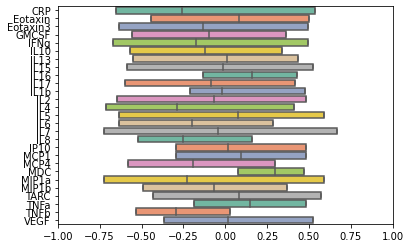

In [13]:
#df.describe()

# plot boxplot
#df_z = df_z.iloc[:,7:35]
ax = sb.boxplot(data=df_z, orient="h", palette="Set2", showfliers=False, whis=0) #fliers is outliers, whis is whiskers
ax.set(xlim=(-1, 1))

# or using import matplotlib.pyplot as plt; plt.ylim(10, 40)

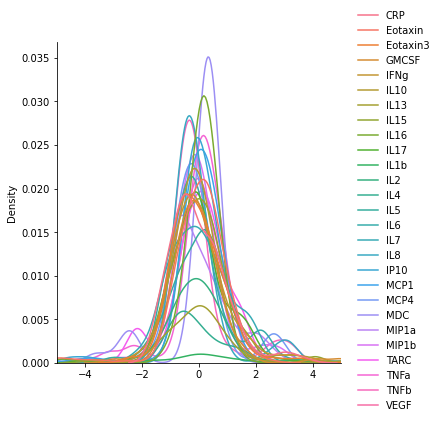

In [14]:
bx = sb.displot(df_z, kind="kde")
bx.set(xlim=(-5, 5))

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **DATA EXPLORATION: RIDGELINE PLOT**

In [15]:
# RIDGELINE PLOT
#unlike in ggridges R, it takes a a few lines to build here

# first copy dataframe
df_z2 = df_z.copy()

#melt it into long format
df_z2 = pd.melt(df_z2)
df_z2

,variable,value
0,CRP,-1.142719
1,CRP,0.200250
2,CRP,-1.142719
3,CRP,-0.003400
4,CRP,0.163939
...,...,...
5611,VEGF,-0.996613
5612,VEGF,-0.662962
5613,VEGF,-0.327122
5614,VEGF,-1.661385


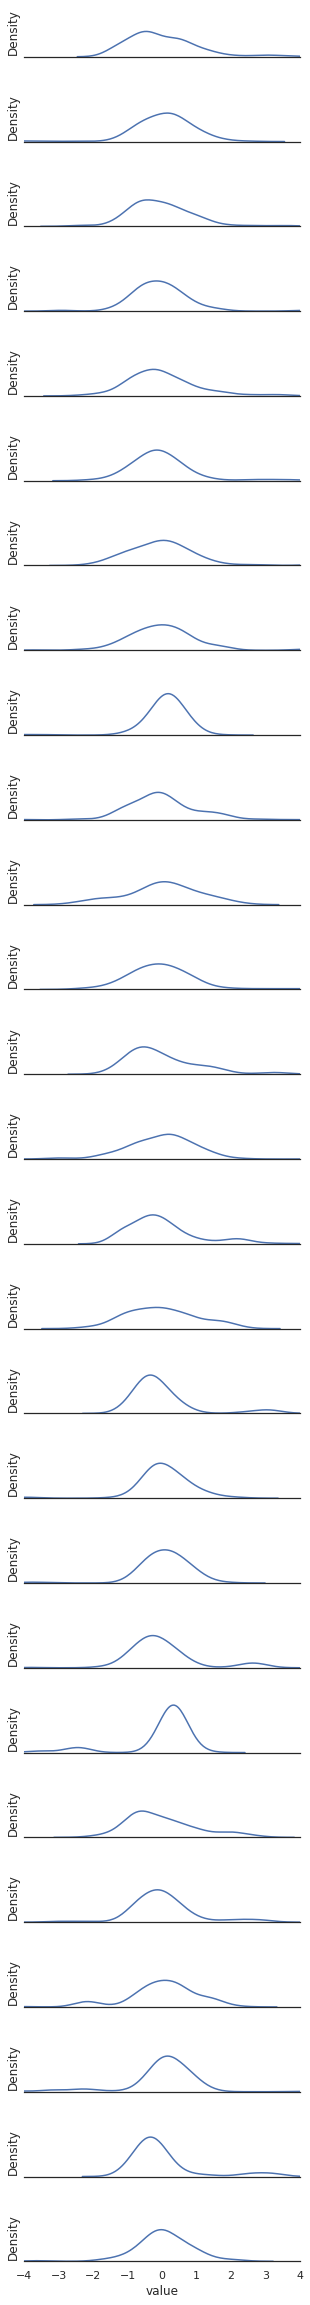

In [16]:
sb.set_theme(style="white")
cx = sb.FacetGrid(df_z2, row='variable', aspect=4, height=1.2) # df must be in longform ie col = variables , row = observations
cx.map_dataframe(sb.kdeplot, x='value')
cx.set_titles("")
cx.set(yticks=[])
cx.set(xlim=(-4, 4))
cx.despine(left=True)

In [17]:
# FINE-TUNING RIDGELINE PLOT

# get colours
import sys
!{sys.executable} -m pip install colorcet # install a pip package in the current Jupyter kernel
import colorcet as cc # this lib can accom more qualitative / categorical colours
palette = sb.color_palette(cc.glasbey_dark, n_colors=27)

/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)
/usr/local/lib/python3.7/dist-packages/seaborn/axisgrid.py:88: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  self._figure.tight_layout(*args, **kwargs)


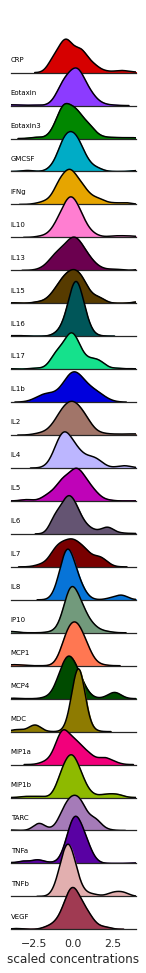

In [18]:
# re-initialize the FacetGrid object
sb.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)}) # axis bg opacity = transparent 
dx = sb.FacetGrid(df_z2, row="variable", palette=palette, hue="variable", aspect=5, height=0.5) # main plot
# hue in sb = third category for data point e.g. akin to colouring data points in scatterplot

# build plot
dx.map_dataframe(sb.kdeplot, x="value", fill=True, alpha=1) # fill 
dx.map_dataframe(sb.kdeplot, x="value", color='black') 

# Define and use a simple function to label the plot in axes coordinates
import matplotlib.pyplot as plt
def label(x, color, label):
    ax = plt.gca() #from pyplot
    ax.text(0, .2, label, color='black', fontsize=7,
            ha="left", va="center", transform=ax.transAxes)

dx.map(label, "variable") # to iterative run function e.g. label, using arguments supplied


# adjust / set things
dx.fig.subplots_adjust(hspace=-.5) # to make plots overlap 
dx.set_titles("") # remove titles for subplot
#dx.set(ylabel=None)  # remove the axis label ie "Density"
dx.set(yticks=[], xlabel="scaled concentrations", ylabel=None, xlim=(-4, 4)) # you can condense all .set para in one
dx.despine(left=True)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **DATA EXPLORATION: CORRELATION HEATMAP**

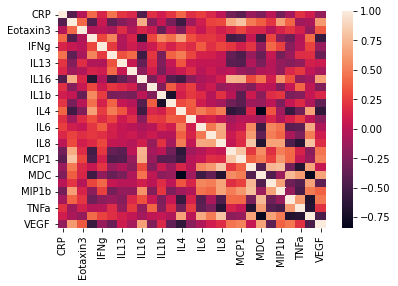

In [13]:
# CORR HEATMAP
df_z.corr() # to make a df x df correlation
sb.heatmap(df_z.corr()) #only those without NaNs shown

In [ ]:
# INITIALIZE corr df (WORK IN PROGRESS)

# make a function that plots corr matrix and thresholds w 'mask' arg that masks corr where p-val > 0.05 
def plot_cor_matrix(corr, mask=None):
    f, ax = plt.subplots(figsize=(11, 9))
    sb.heatmap(corr, ax=ax,
                mask=mask,
                # cosmetics
                annot=False, vmin=-1, vmax=1, center=0, #annot to show r
                cmap='coolwarm', linewidths=2, linecolor='white', cbar_kws={'orientation': 'horizontal'})
    
# plot without signif thresholding
hx = df_z.corr()
mask = np.triu(hx) # get upper tri
plot_cor_matrix(hx,mask)
#plt.show()

In [ ]:
# FINE-TUNING HEATMAP  ## not NaN tolerant (WORK IN PROGRESS)

# define fxn to extract p-value
def corr_sig(df=None):
    p_matrix = np.zeros(shape=(df.shape[1],df.shape[1]))
    for col in df.columns:
        for col2 in df.drop(col,axis=1).columns:
            r , p = stats.pearsonr(df[col],df[col2]) # this is from scipy.stats.pearsonr, spits r and p-val
            p_matrix[df.columns.to_list().index(col),df.columns.to_list().index(col2)] = p 
    return p_matrix


# Plotting with significance filter
ix = df_z.corr()                            # get correlation
p_values = corr_sig(df_z)                   # get p-Value
mask = np.invert(np.tril(p_values<0.05))    # mask - only get significant corr, tril = lower tri, invert =
plot_cor_matrix(ix,mask)  

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLASSIFICATION: BUILDING A BASE MODEL (XGB)**

In [13]:
######## XGBoost classifier ###############

# importing libraries
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


In [14]:
#!pip3 install xgboost # install a pip package in the current Jupyter kernel
# XGB installed at the start
from xgboost import XGBClassifier

In [15]:
# DEFINE FEATURES
X = df_z # 208 x 27


# DEFINE LABELS / ONE-HOT ENCODING (for categorical vars)
y = df[["crpGroup"]] # 208 x 1

# initialize (encode labels with value between 0 and n_classes-1)
le = preprocessing.LabelEncoder()

# fit and transform (use df.apply() to apply le.fit_transform to all columns e.g. to X)
y2 = y.apply(le.fit_transform)
y2.head()  #Low inflammation = 1; High inflammation = 0

,crpGroup
0,1
1,1
2,1
3,1
4,1


In [16]:
#split in train and test 
X_train, X_test, y_train, y_test = train_test_split(X, y2, test_size=0.3, random_state=1) 

#test size; 30% is held out for test/validation, random sate 

In [17]:
# define base model 
model = XGBClassifier() #does not have specific configs

In [77]:
# fit model on training data
model.fit(X_train, y_train) # there are many hyperparameters - general, booster, learning, 

[23:39:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [57]:
# predict / apply on test data
y_pred = model.predict(X_test) # only provide X, because y_test contains our answer labels
y_pred

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0])

In [58]:
# check answer / accuracy 
accuracy = accuracy_score(y_test, y_pred)
accuracy  

1.0

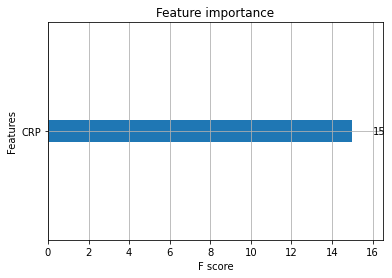

In [59]:
# FEATURE IMPORTANCE PLOT
from xgboost import plot_importance
from matplotlib import pyplot

plot_importance(model) # plots loadings, you can also make it yourself. But this is from XGB
pyplot.show()

Accuracy is 100% and weighting is high on CRP because CRP levels = labels, ie you've already included answer on your training X.

In [60]:
########## rerun w new model - w/o CRP as feature col ########

# DEFINE FEATURES
X_2 = df_z.iloc[: , 1:] # 208 x 26 # from col 1 onwards selected, col 0 is dropped
X_2.head()

,Eotaxin,Eotaxin3,GMCSF,IFNg,IL10,IL13,IL15,IL16,IL17,IL1b,...,IP10,MCP1,MCP4,MDC,MIP1a,MIP1b,TARC,TNFa,TNFb,VEGF
0,1.210629,-0.002150,0.121644,0.569337,-0.117863,0.847968,0.670539,0.684703,-1.048995,-0.097378,...,0.602269,0.877362,2.715387,-2.781593,1.261296,2.301529,-2.347156,-4.026748,2.546643,NaN
1,-0.363245,0.076020,-0.557759,-0.282099,-0.202743,NaN,-0.587835,-0.111966,0.826708,NaN,...,-0.089219,0.057617,-0.607317,0.556840,-1.012764,-0.174901,0.278647,0.118752,-0.265377,-0.194549
2,1.287081,-0.123481,-1.376693,-1.338247,-0.500252,NaN,0.166955,0.628799,-1.956701,NaN,...,-0.170542,0.248868,0.143974,0.406764,NaN,0.287116,1.463617,-0.285051,-0.970779,0.394306
3,-0.919791,-0.236115,-0.433784,0.037164,-0.583569,NaN,-0.488447,0.317450,-0.923244,NaN,...,0.015432,-0.744859,-0.675338,0.485417,-0.405231,-0.348972,-0.827640,-0.068868,-0.878153,-0.368941
4,0.554357,0.549172,-1.044847,0.326401,0.710306,0.298722,-1.615116,-0.390942,-0.838140,NaN,...,-0.047465,0.253225,-0.942244,0.075451,-0.451006,-0.029038,-0.546272,-0.070114,-0.776131,1.758514


In [61]:
#split in train and test 
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_2, y2, test_size=0.3, random_state=1) 

In [62]:
# fit model on new data
model.fit(X_train2, y_train2)

[23:35:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/usr/local/lib/python3.7/dist-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=2, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [63]:
# predict / apply on test data
y_pred2 = model.predict(X_test2) # only provide X, because y_test contains our answer labels
y_pred2

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


array([1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0])

In [64]:
# REAL answers / labels (Low inflammation = 1, High inflammation = 0) # classes are not balanced ie 50-50
unique, counts = np.unique(y_test2, return_counts=True)
np.asarray((unique, counts)).T

array([[ 0, 14],
       [ 1, 49]])

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLASSIFICATION: EVALUATING MODEL PERFORMANCE**

In [65]:
# ACCURACY (total correct preds / total number of predictions; [TP + TN] / [TP + TN + FP + FN])
accuracy = accuracy_score(y_test2, y_pred2)
accuracy  

0.7301587301587301

Accuracy of 0.73 or 73% appears good. But, this is a class-imbalanced dataset (see previous cell with true label counts) ie there is a significant disparity between the number of positive(1) and negative(0) labels. So, in an imbalanced dataset, high accuracy could be heavily weighted or biased on accuracy of prediction of one label over another, when in reality - for the other (smaller) class - correct classification was actually poor.

Better metrics for imbalanced dataset: *Precision* and *Recall*.

In [66]:
# Report with all metrics 
from sklearn.metrics import classification_report
print(classification_report(y_test2, y_pred2)) # ground truth labels vs prediction by classifier

              precision    recall  f1-score   support

           0       0.42      0.57      0.48        14
           1       0.86      0.78      0.82        49

    accuracy                           0.73        63
   macro avg       0.64      0.67      0.65        63
weighted avg       0.77      0.73      0.74        63



Typically, recall and precision for label=1 (in this case "Low inflammation") is more commonly examined rather for both labels.

In [67]:
# RECALL (SENSITIVITY) - proportions of True Pos from all ACTUAL positives (here TP is label=1) [formula: TP / (TP + FN)]
from sklearn.metrics import recall_score 
recall_score(y_test2,y_pred2)

0.7755102040816326

Our model has a recall of 0.78 - it correctly identified 78% of "Low inflammation" MDD patients. *(see normalized confusion matrix - corresponds with LowerRight quadrant; TP)*.

In [68]:
# PRECISION - proportions of True Pos from all IDENTIFIED as positive (here TP is label=1) [formula: TP / (TP + FP)]
from sklearn.metrics import precision_score 
precision_score(y_test2,y_pred2)

0.8636363636363636

Our model has a precision of 0.86 - in other words, when it predicts "low inflammation" in an MDD patient or classifies an MDD patient as "Low inflammation", it is correct 86% of the time.

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


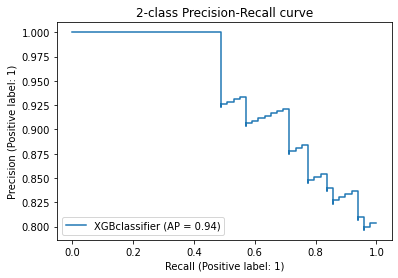

In [69]:
# PRECISION-RECALL CURVE (for 2-labels/ binary classifier) https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    model, X_test2, y_test2, name="XGBclassifier"
)
_ = display.ax_.set_title("2-class Precision-Recall curve") 

# model is your classifer defined earlier / fitted to data


Interpretation: this curve is useful to examine trade-off in precision made when desiring high recall. From this curve, as recall increases ( > 0.5 or 50%), there is a sharp decline in precision. However, because XGB is a good model, here you are able to attain 1.0 or 100% recall *without* comprising too much on precision ie you still get precision approx 81% at recall 100%. 

In [70]:
# CONFUSION MATRIX ie indication of errors in classification / "confusion" experienced by classifier

from sklearn.metrics import confusion_matrix
 
expected = y_test2
predicted = y_pred2
#results = confusion_matrix(expected, predicted)
#print(results)
tn, fp, fn, tp = confusion_matrix(expected, predicted).ravel()
tn, fp, fn, tp

(8, 6, 11, 38)

Confusion matrix, without normalization
[[ 8  6]
 [11 38]]
Normalized confusion matrix
[[0.57142857 0.42857143]
 [0.2244898  0.7755102 ]]


/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  "because it will generate extra copies and increase " +


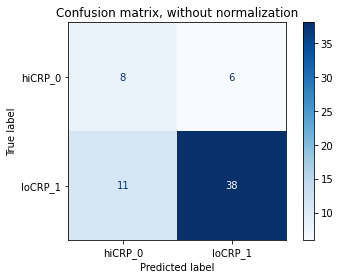

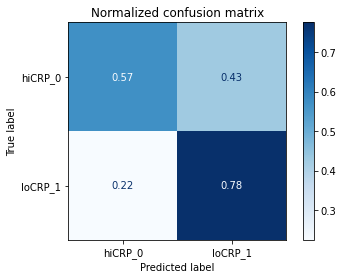

In [71]:
# CONFUSION MATRIX PLOT

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

class_names = ["hiCRP_0", "loCRP_1"] # 1 = positive, 0 = negative... how do labels work ?

title_options = [
    ("Confusion matrix, without normalization", None),
    ("Normalized confusion matrix", "true"),
]
for title, normalize in title_options:
    display = ConfusionMatrixDisplay.from_estimator(
        model,
        X_test2,
        y_test2,
        display_labels=class_names,
        cmap=plt.cm.Blues,
        normalize=normalize,
    )
    display.ax_.set_title(title)

    print(title)
    print(display.confusion_matrix)

plt.show() # UpperL = TN, LowerL = FN, UR = FP, LR = TP (see if it matches output in prev cell)

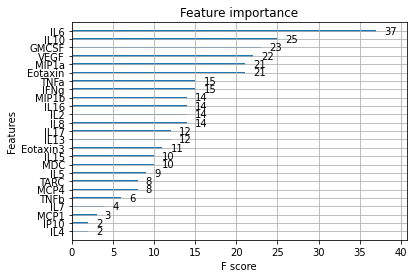

In [72]:
# FEATURE IMPORTANCE
plot_importance(model, importance_type='weight') # plot using built-in XGB plot tool; default importance = "weight"
pyplot.show()

#see this for more info https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7




Interpretation: After dropping CRP (feature that label was derived from), IL6 is(quite accurately) weighing heavily towards label prediction. CRP is biologically highly correlated w IL6. 

XGBoost computes mulitple importance types ie 
(i) "weight" (F/F1-score) - the number of times a feature is used to split the data across all trees, 
(ii) "coverage"- , and the most important 
(iii) "gain" - reflecting improvement in accuracy brought about by a feature to the branches it is on, adds up to 1. 

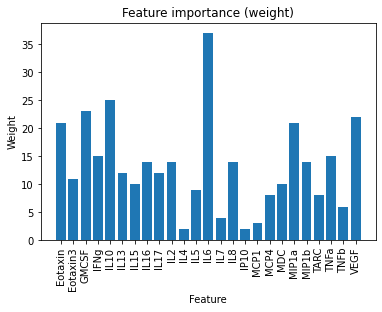

In [73]:
 # Manually plotting 

# get importance
#importance = model.feature_importances_ # this only plots "gain"
importance = model.get_booster().get_score(importance_type='weight') # a dictionary

# summarize feature importance
#for i,v in enumerate(importance):
	#print('Feature: %0d, Score: %.5f' % (i,v))
 
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

# plot feature importance (if dictionary)
imp = importance.items()
imp = sorted(imp) # retains order in input data array (X_test)
x, y = zip(*imp)

plt.bar(x, y)
plt.xlabel('Feature')
plt.xticks(rotation=90)
plt.ylabel('Weight')
plt.title('Feature importance (weight)')
plt.show()



In [ ]:
#### EXTRA - plot SHAP figures (Shapley Additive Explanations) https://github.com/slundberg/shap

!pip install shap
import shap as shap

#publication: https://www.nature.com/articles/s41551-018-0304-0.epdf?author_access_token=vSPt7ryUfdSCv4qcyeEuCdRgN0jAjWel9jnR3ZoTv0PdqacSN9qNY_fC0jWkIQUd0L2zaj3bbIQEdrTqCczGWv2brU5rTJPxyss1N4yTIHpnSv5_nBVJoUbvejyvvjrGTb2odwWKT2Bfvl0ExQKhZw%3D%3D

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


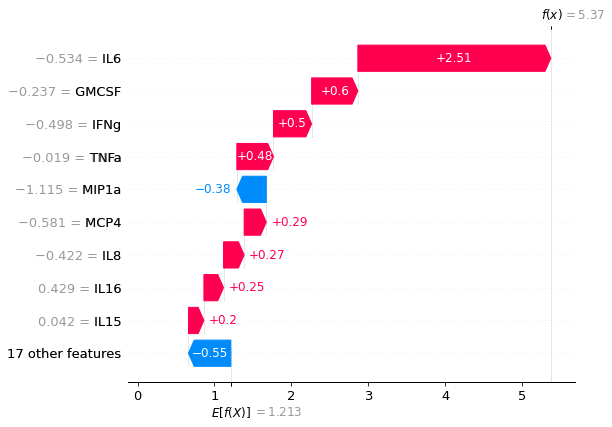

In [75]:
## make SHAP composite plot

# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)
shap_values = explainer(X_test2)

# visualize the first prediction's explanation
shap.plots.waterfall(shap_values[0])


Interpretation: Plot shows features each contributing to push the model output from the base value (the average model output over the training dataset that was passed) to the model output. Features pushing the prediction higher are shown in red, those pushing the prediction lower are in blue.

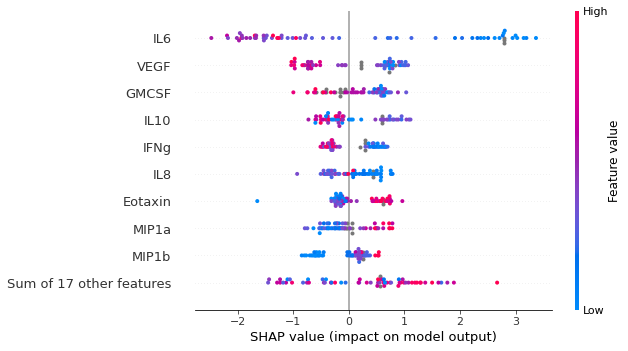

In [76]:
# summarize the effects of all the features
shap.plots.beeswarm(shap_values)

Interpretation: To get an overview of which features are most important for a model (like another feature importance) - we could plot the SHAP values of every feature for EVERY SAMPLE (each dot). The plot above sorts features by the sum of SHAP value magnitudes over all samples, and uses SHAP values to show the distribution of the impacts each feature has on the model output. The color of dots represents the feature value (red = high, blue = low), and direction reflects impact on model (left, negative impact = label 0 ie "high inflammation" | right, positive impact = label 1 ie "low inflammation").

Here, IL6 has higher feature value in the left / negative direction - suggesting a high level of this is more likely to predict "high inflammation".

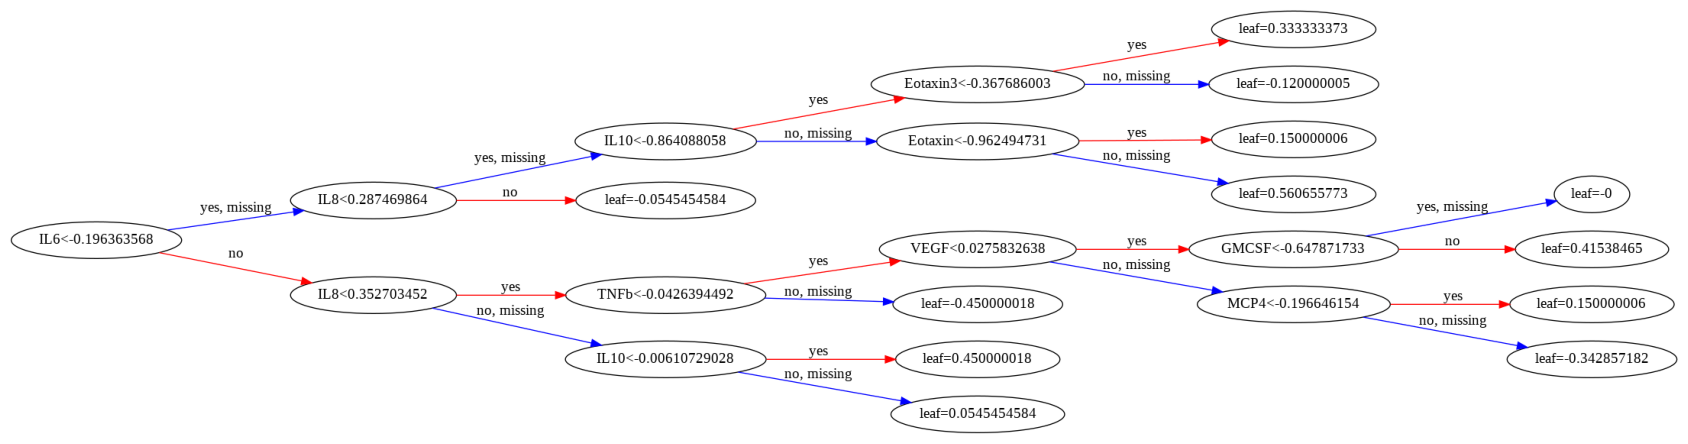

In [48]:
# Plot decision trees in XGB model
from xgboost import plot_tree

plot_tree(model, num_trees=0, rankdir='LR') 
fig = plt.gcf()
fig.set_size_inches(30, 15) # adjust size

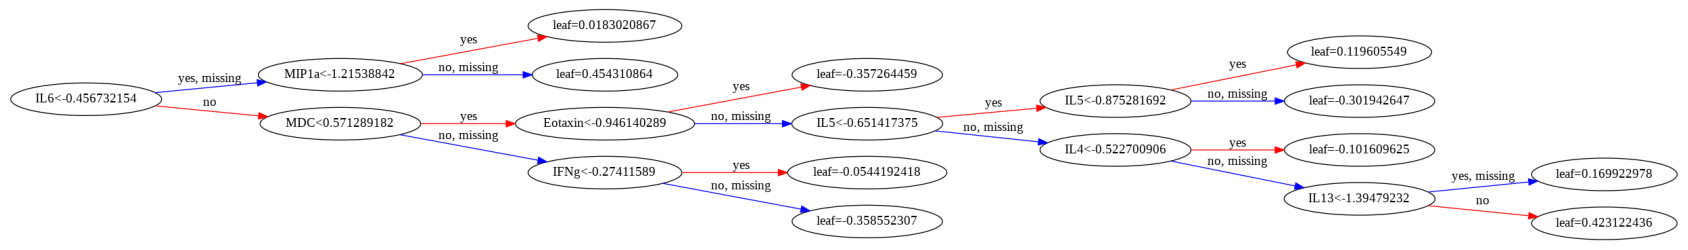

In [49]:
plot_tree(model, num_trees=1, rankdir='LR') # these are different trees in the "forest" / ensemble
fig = plt.gcf()
fig.set_size_inches(30, 15) # adjust size

Interpretation: Since XGB is an ensemble-based method or model - there are many many trees instantiated, each perhaps "specialised" towards some component of input data / classification task. The number of decision trees is flagged by **n_estimators** parameter in XGBClassifier, where the default is n=100 (depth or size of each tree is denoted by **max_depth** flag). 

Part of model selection or hyperparameter optimisation is to perform cross validation via grid search over a parameter eg. over different number of decision trees. (SEE NEXT CELL)

% Decision tree anatomy - root decision node (IL6), nodes that have progenitors = decision nodes, nodes that don't = leaf / terminal nodes. At each level (starting at the root node), model asks "is feature < -(whatever value) ?"

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLASSIFICATION: HYPERPARAMETER TUNING & MODEL OPTIMISATION / SELECTION**

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


[14:06:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best: -0.648813 using {'n_estimators': 50}
-0.648813 (0.134174) with: {'n_estimators': 50}
-0.679412 (0.139639) with: {'n_estimators': 100}
-0.692314 (0.150277) with: {'n_estimators': 150}
-0.699264 (0.157088) with: {'n_estimators': 200}
-0.713428 (0.158346) with: {'n_estimators': 250}
-0.722456 (0.155650) with: {'n_estimators': 300}
-0.722615 (0.150714) with: {'n_estimators': 350}


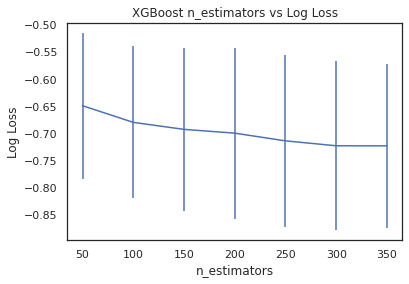

In [51]:
# Model selection using Grid search cross-validation (GridSearch CV)

# finding optimal number of decision trees to use in XGB classifier (flag: n_estimators)

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# grid search
#model = XGBClassifier() #already defined above
n_estimators = range(50, 400, 50) # folds of 50, from 50 - 400 trees
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(model, param_grid, scoring="neg_log_loss", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train2, y_train2) # fit on TRAINING data

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))
 
# plot
pyplot.errorbar(n_estimators, means, yerr=stds)
pyplot.title("XGBoost n_estimators vs Log Loss")
pyplot.xlabel('n_estimators')
pyplot.ylabel('Log Loss')
pyplot.savefig('n_estimators.png')

Interpretation: Following grid search, we can see that the best or optimal number of trees is n=50 (Best: -0.648813 using {'n_estimators': 50}). Log loss does not improve ie continues to decrease with more trees. 

Next, we redefine XGB classifier using optimal number of decision trees, and fit the new model on test data to predict labels. 

In [ ]:
# instantiate new XGB classifier and fit to train data
model_xgb2 = XGBClassifier(n_estimators=50)
model_xgb2.fit(X_train2,y_train2)

# use new model to predict on test data
y_pred2_xgb2 = model_xgb2.predict(X_test2)

In [76]:
# examine new accuracy, recall and precision 
print(accuracy_score(y_test2, y_pred2_xgb2)) # original model; 73%
print(recall_score(y_test2, y_pred2_xgb2)) # original model; 77.6%
precision_score(y_test2, y_pred2_xgb2) # original model; 86.4%


0.746031746031746
0.7959183673469388


0.8666666666666667

Interpretation: We see a marginal improvement (an improvement nonetheless) using n=50 trees instead of the original, default n=100 trees. 

The identical approach could be applied to optimise other hyperparameters using grid search and generalized across other types of classifers.

see here for info https://towardsdatascience.com/cross-validation-and-grid-search-efa64b127c1b

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLASSIFICATION: COMPARING BASE MODEL (XGB) PERFORMANCE TO OTHER CLASSIFIERS**

In [63]:
##### Compare classifiers: XGB (our base model; ENSEMBLE BOOSTING classifier) vs Logistic Regression

# %%%%%%%%%% Log Reg : MUST IMPUTE - DOES NOT HANDLE NaNs %%%%%%%%%

# prep X data 
X_lr = X_2.copy()

# simple imputation (univariate)
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean', missing_values=np.nan) # initialize imputer, use mean, look for NaN
imputer = imputer.fit(X_lr) # fit on data

# apply imputer on features
X_lr = imputer.transform(X_lr) # data to impute

#split in train and test 
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_lr, y2, test_size=0.3, random_state=1) 

#test size; 30% is held out for test/validation, random sate 

In [74]:
# Import the model we are using
from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestRegressor

# Instantiate model 
model_lr = LogisticRegression()
#model_rf = RandomForestRegressor()

# Train the model on training data
model_lr.fit(X_train3, y_train3)
#model_rf.fit(X_train2, y_train2)

# Predict method on the test data
y_pred2_lr = model_lr.predict(X_test3)
#y_pred2_rf = rf.predict(X_test3)


# View metrics
print(accuracy_score(y_test3, y_pred2_lr)) # tuned XGB; 74.6%
print(recall_score(y_test3, y_pred2_lr)) # tuned XGB; 79.6% 
precision_score(y_test3, y_pred2_lr) # tuned XGB; 86.7%

0.7142857142857143
0.8367346938775511


A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


0.803921568627451

Interpretation: With logistic regression, there is better recall compared to our base model (XGB). But it is important to remember that NaNs in input data were imputed (with mean)...

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLUSTERING: GMM**

In [28]:
############## CLUSTERING W GMM ################

#load libraries
from sklearn.impute import SimpleImputer
from sklearn import mixture
import matplotlib.pyplot as plt


In [29]:
# prep data 
X_gmm = df_z.copy()

# simple imputation (univariate)
imputer = SimpleImputer(strategy='median', missing_values=np.nan) # initialize imputer, use mean, look for NaN
imputer = imputer.fit(X_gmm) # fit on data


In [30]:
# apply imputer on data
X_gmm = imputer.transform(X_gmm)
X_gmm # data to input 

array([[-1.14271869e+00,  1.21062859e+00, -2.14951807e-03, ...,
        -4.02674805e+00,  2.54664268e+00,  1.54694333e-02],
       [ 2.00249801e-01, -3.63244812e-01,  7.60203812e-02, ...,
         1.18751982e-01, -2.65377434e-01, -1.94548869e-01],
       [-1.14271869e+00,  1.28708141e+00, -1.23480702e-01, ...,
        -2.85050610e-01, -9.70779492e-01,  3.94305805e-01],
       ...,
       [-2.90428083e-01, -1.51606902e+00, -7.87921407e-01, ...,
        -2.66342994e-01, -9.55575924e-03, -3.27122480e-01],
       [-1.14271869e+00, -4.63606154e-01,  7.40203483e-02, ...,
         6.18983486e-01, -1.05525278e+00, -1.66138489e+00],
       [ 6.54617237e-01, -4.73248960e-01,  1.47472195e-01, ...,
         8.86275607e-01, -3.87489793e-01, -1.06494158e+00]])

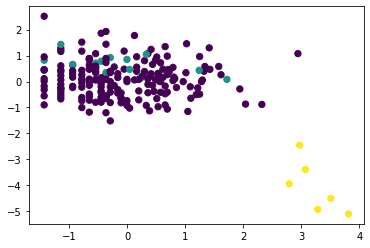

In [51]:
# run GMM 
gmm = mixture.GaussianMixture(n_components=3).fit(X_gmm) # you do not need to know prior
labels = gmm.predict(X_gmm) # gives you cluster assignment for each sample
plt.scatter(X_gmm[:, 0], X_gmm[:, 1], c=labels, s=40, cmap='viridis'); # you're plotting col 1 and col 2 from array

# set seed if you dont random output - when you pass seed, you will reproduce output

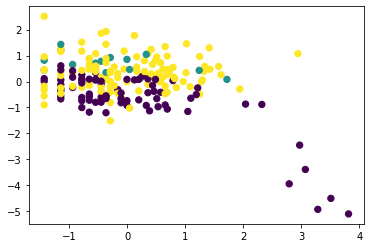

In [53]:
gmm = mixture.GaussianMixture(n_components=3).fit(X_gmm) # you do not need to know prior
labels = gmm.predict(X_gmm) # gives you cluster assignment for each sample
plt.scatter(X_gmm[:, 0], X_gmm[:, 1], c=labels, s=40, cmap='viridis'); # you're plotting col 1 and col 2 from array

Reproducibility of mixture model results: In addition to having to select / define optimal number of components yourself, GMM is not deterministic ie running the model twice - with same number of components - would not results in same cluster identity for each sample. Try running GMM twice and note scatterplot data point aggregation ie are the same data points always making up the same cluster... 

This property is controlled by "random_state" paramater or seeds used to initiliaze/restart algorithm. Default "None" uses the global random state instance from np.random. Calling the function multiple times will reuse the same instance, and will produce different results.

For reproducible results - set seed integer. Popular integer random seeds are 0 and 42.

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLUSTERING: (OPTIONAL) DATA EXPLORATION - DO GMM CLUSTERS ACCORD WITH VARIATION IN PC SCORES ?**

In [31]:
# perform dimensionality reduction across all features 

from sklearn.decomposition import PCA

df_X_gmm = pd.DataFrame(X_gmm) 


In [46]:
pca = PCA(n_components=24) # 25 cols (w/o CRP); your model where you will find EV, loadings etc
principalComponents = pca.fit_transform(df_X_gmm) # fit model on data

In [47]:
principalComponents

array([[ 7.72620887, -1.79445143, -1.19361892, ..., -0.06981422,
        -0.30132757,  0.26766963],
       [-1.10087614,  0.31750502,  0.48951535, ...,  0.18577945,
        -0.23631222,  0.42445361],
       [-1.30587912, -2.29263681, -1.48777242, ...,  0.21259619,
         0.26375262,  0.01920275],
       ...,
       [-0.33568263,  0.65465551, -1.38971117, ..., -0.04814284,
        -0.52967431,  0.48491331],
       [-0.77767573, -0.22507627, -0.70786786, ...,  0.44534022,
         0.15395763, -0.13094849],
       [ 0.05661849,  0.53033416,  2.02314365, ...,  0.1267407 ,
        -0.09293899,  0.32216715]])

In [48]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['PC1','PC2','PC3','PC4','PC5','PC6','PC7','PC8','PC9','PC10',
                          'PC11','PC12','PC13','PC14','PC15','PC16','PC17','PC18','PC19','PC20','PC21','PC22',
                          'PC23','PC24'])

In [54]:
# biplot - PC scores, with cluster labels coloured

# make df to plot
toplot = principalDf.copy()
toplot['GMM_labels'] = labels # from whichever GMM above

toplot.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,GMM_labels
0,7.726209,-1.794451,-1.193619,0.129696,-0.711770,1.385919,-0.822583,1.129075,-0.847572,0.204621,...,1.662561,0.222568,0.232845,0.569496,0.124713,-0.047197,-0.069814,-0.301328,0.267670,1
1,-1.100876,0.317505,0.489515,0.153209,1.015954,-0.110409,0.199929,0.208259,-1.624829,0.391925,...,0.938952,-0.399760,0.061244,-0.217081,-0.129416,-0.057701,0.185779,-0.236312,0.424454,2
2,-1.305879,-2.292637,-1.487772,0.795299,-0.920676,1.308988,-0.836859,-0.860651,-0.126263,-0.408990,...,-0.651555,-0.328567,0.431962,-0.270342,-0.088899,0.175215,0.212596,0.263753,0.019203,2
3,-1.180062,0.393263,-1.814345,-0.460742,-0.293029,-1.144645,-0.489941,0.065831,0.240849,0.623819,...,-0.076200,0.008011,-0.623849,-0.258389,0.056169,0.219320,0.297428,0.116926,-0.469678,0
4,-0.529381,-0.805218,-0.893270,1.537399,-0.309708,-1.921205,-0.432234,0.354910,0.748692,-1.138925,...,-0.039368,0.618098,-0.047075,-0.101818,0.404955,0.711284,-0.246795,0.336573,0.378870,2


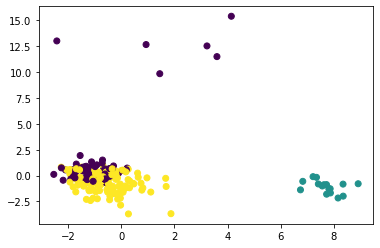

In [55]:
# scatterplot - PC scores, with cluster labels coloured

plt.scatter(toplot['PC1'], toplot['PC2'], c=labels, cmap='viridis') # x,y


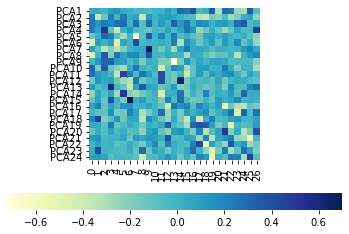

In [43]:
# plot loadings
ax = sb.heatmap(pca.components_,
                 cmap='YlGnBu',
                 yticklabels=[ "PCA"+str(x) for x in range(1,pca.n_components_+1)],
                 xticklabels=list(df_X_gmm.columns),
                 cbar_kws={"orientation": "horizontal"})
ax.set_aspect("equal")

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLUSTERING: GMM - DETERMINING OPTIMAL NUMBER OF COMPONENTS**

In [32]:
####  Simulate multiple GMM models and select optimal number of components #####

# define array with component numbers
n_components = np.arange(1, 41) # simulate 10 diff models, with max 1 - 10 no of components, # push more ie 20 30 etc.

# run models 
models = [mixture.GaussianMixture(n, 
                          covariance_type='full', random_state=0).fit(X_gmm) for n in n_components] # X_gmm is your input df

# calculate BIC for all models 
gmm_model_bic=pd.DataFrame({"n_components" : n_components,
                                  "BIC" : [m.bic(X_gmm) for m in models],
                            "AIC" : [m.aic(X_gmm) for m in models]}) #model.bic(input df) calculates BIC #AIC can be used for comparison

Text(0, 0.5, 'Score')

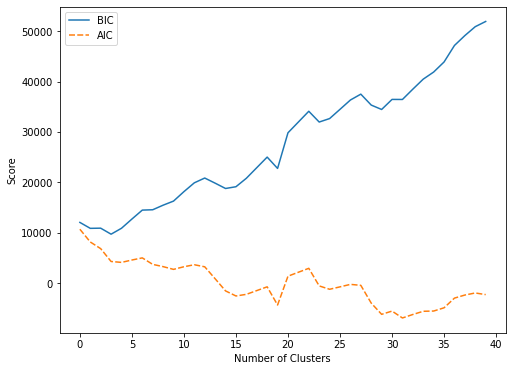

In [33]:
# Elbow plot
plt.figure(figsize=(8,6))
sb.lineplot(data=gmm_model_bic[["BIC", "AIC"]]) # not necessarily dec and plateau
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
#plt.savefig("GMM_model_BIC_Scores_Python.png", format='png',dpi=150)

Interpretation: This looks weird ie very erratic apart from sharp elbow at n=20... 

In general, lower BIC is better, select elbow (Ncomp =20). AIC appears to corroborate this.

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLUSTERING: BAYESIAN GMM**

In [34]:
######### Bayesian GMM ########

from sklearn.mixture import BayesianGaussianMixture

n_components=20 # set it to a big number
model_bgmm = BayesianGaussianMixture(weight_concentration_prior= 1/(5*n_components), n_components=n_components, 
                                     random_state=42)
model_bgmm = model_bgmm.fit(X_gmm)


In [35]:
# evaluate cluster weights to retain / selection meaningful ones

model_bgmm.weights_ 


array([0.04784602, 0.04284612, 0.00947177, 0.07537747, 0.0187373 ,
       0.07917326, 0.1110621 , 0.04133751, 0.16876026, 0.00901193,
       0.06237447, 0.01319003, 0.05638413, 0.00853451, 0.00839454,
       0.11128651, 0.0681008 , 0.0113505 , 0.03901898, 0.0177418 ])

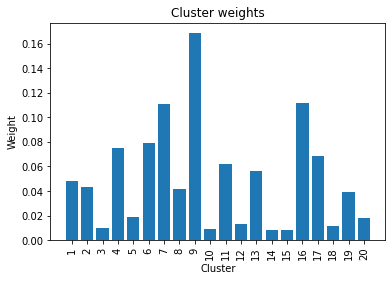

In [36]:
# Plot cluster weights - data-driven cluster number selection

a = np.arange(1,21)
b = model_bgmm.weights_ 

plt.bar(a, b)
plt.xlabel('Cluster')
plt.xticks(a, rotation=90)
plt.ylabel('Weight')
plt.title('Cluster weights')
plt.show()



Interpretation: Bar chart indicates that optimal number of components or clusters is 18 (weight > 0.01).

In [39]:
# rerun bGMM with 15 components and get cluster assignment for each sample

n_components=15 
model_bgmm15 = BayesianGaussianMixture(weight_concentration_prior= 1/(5*n_components), n_components=n_components,
                                       random_state=42)
model_bgmm15 = model_bgmm15.fit(X_gmm)

In [40]:
labels_bgmm = model_bgmm15.predict(X_gmm)
labels_bgmm

array([ 4,  8,  8,  5,  1,  5,  1,  8,  6,  6,  6,  8,  6,  3,  1,  1,  8,
        1,  3,  7,  1, 12,  0, 12,  8,  1,  5,  5,  8,  5,  0,  8,  8, 12,
        8,  6,  8,  7,  6,  1,  8,  6,  0,  8,  8,  6,  8,  0,  1,  3,  8,
        6,  6,  3,  1,  1,  8,  8, 10,  3, 10,  1,  0,  8,  8, 10, 10,  1,
       12,  8,  8, 10,  7,  6, 10, 10,  8,  8,  3,  8,  8,  1, 10,  6,  6,
        1, 10,  8,  7,  8,  5, 10,  3,  4, 10,  5,  6,  8,  8,  3, 12,  0,
        0,  5,  8,  5,  3,  8,  2,  8,  5,  1,  6,  3, 10,  5,  8,  8,  8,
        5,  5,  5,  3,  1,  3,  5,  5,  6,  5,  5,  5,  8,  5,  6,  6,  6,
        5,  0,  8,  5,  5,  6,  3,  0,  5,  8,  8,  8,  8, 12, 12,  0,  7,
       12, 12,  6,  3, 12,  0, 12, 14, 12,  6,  1,  6, 12,  5, 12,  7,  8,
        3,  6,  0,  6,  0, 10,  6,  3,  1,  5, 13, 11,  3,  6,  8,  6,  8,
       11,  0,  0,  1,  5,  6, 12,  9,  8,  6,  6,  1,  1,  4,  8,  1,  7,
        6,  5,  5,  7])

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **CLUSTERING: exploring clusters from Bayesian GMM**

In [79]:
#### Understand each cluster 

# subset original dataframe
df_chr = df.iloc[:,1:8]

# append cluster assignments to main df
df_chr['Cluster_bGMM'] = labels_bgmm.tolist()

# append PC scores main df
pc1 = principalDf['PC1'] 
df_chr['PC1'] = pc1.tolist()
pc2 = principalDf['PC2'] 
df_chr['PC2'] = pc2.tolist()

df_chr.head()

,Centre,Study.Arm,Sex,BMI,Age,crpGroup,CRP,Cluster_bGMM,PC1,PC2
0,Cambridge,HAM-D > 13 on medication,Female,24.943310657596,55.8,Low CRP Depression,0.3,4,7.726209,-1.794451
1,Cambridge,HAM-D < 7 on medication,Female,25.259515570934,52.3,Low CRP Depression,2.0,8,-1.100876,0.317505
2,Cambridge,HAM-D < 7 on medication,Male,18.354723089374,42.4,Low CRP Depression,0.3,8,-1.305879,-2.292637
3,Cambridge,HAM-D > 13 on medication,Female,36.419526212035,40.3,Low CRP Depression,1.5,5,-1.180062,0.393263
4,Cambridge,HAM-D > 13 on medication,Female,20.266439909297,47.3,Low CRP Depression,1.9,1,-0.529381,-0.805218


In [102]:
# explore characteristics of each cluster / subgroup 

print(df_chr['Cluster_bGMM'].value_counts())
toplot2 = df_chr.groupby(['Cluster_bGMM']).mean()
toplot2

8     47
6     32
5     29
1     23
3     17
12    15
0     15
10    13
7      8
4      3
11     2
2      1
14     1
13     1
9      1
Name: Cluster_bGMM, dtype: int64


,Age,CRP,PC1,PC2
Cluster_bGMM,,,,
0,46.686667,10.993333,-0.330545,-1.031401
1,41.756522,0.804348,-1.312001,0.268484
2,NaN,100.417337,3.602294,11.485440
3,41.335294,4.835294,-0.113991,-1.648744
4,52.333333,1.600000,8.077640,-1.979787
5,37.486207,1.268966,-1.222056,0.315842
6,43.937500,5.081250,-0.443352,0.320363
7,39.012500,3.325000,0.428286,0.014176
8,40.525532,1.621277,-1.156099,-0.413858


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


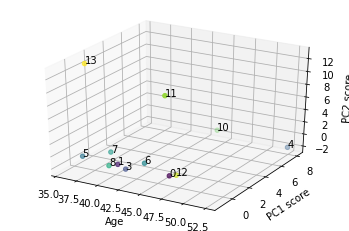

In [127]:
### Matplotlib-based 3D plot 

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()

# Create 1 3D subplot:
# ‘111’ is a MATlab convention used in Matplotlib
# to create a grid with 1 row and 1 column. 
# The first cell in the grid is the new Axes location.
jx = fig.add_subplot(111, projection='3d')

# Create x,y,z coordinates:
x = toplot2['Age']
y = toplot2['PC1']
z = toplot2['PC2']

# create marker index (cluster gorup)
clust_ind = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]

# Create a 3D scatter plot with x,y,z orthogonal axis
jx.scatter(x, y, z, c=clust_ind, cmap='viridis')

# Create x,y,z axis labels:
jx.set_xlabel('Age')
jx.set_ylabel('PC1 score')
jx.set_zlabel('PC2 score')

for xcod,ycod,zcod,i in zip(x,y,z,clust_ind):
    jx.text(xcod,ycod,zcod,i)

plt.show()

In [130]:
# Interactive 3D plot with plotly (Mean for each cluster)

import plotly.express as plotly

kx = plotly.scatter_3d(toplot2, x='Age', y='PC1', z='PC2',
                    color=clust_ind)
kx.show()

Interpretation: Based on mean values for each cluster, Clusters 10, 11 and 13 appear to be quite different than other clusters. However, clusters 11 and 13 have N = 1 and 2 respectively. Thus, observation here is not meaningful.

In [131]:
# Interactive 3D plot with plotly (per sample scatter plot)

lx = plotly.scatter_3d(df_chr, x='Age', y='PC1', z='PC2',
                    color='Cluster_bGMM')
lx.show()

Interpretation: Upon examining individual data points, corroborating mean plot above, most of Cluster 10 data points/constituent samples are indeed distributed separately ie away from main datapoint cloud. In particular, this is in relation to PC1 score, that is samples have higher PC1 score. (PC1 = weighted average of  signalling blood immune proteins)

⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡⚡ **SUMMARY**

***1 - CLASSIFICATION***

*   Our base model (XGB classifier) yielded greater accuracy and precision when predicting general inflammation status or immune state of depression cases using a collection of blood immune proteins, compared to a simpler logistic regression classifier.

*   Feature importance (weight) examination revealed that of the 27 blood immune proteins, IL6 -- a small blood immune protein known to be biologically highly correlated with a general marker of peripheral inflammation or immune state (CRP) -- was the most important feature in correcly predciting ground truth labels. 

*   Interestingly, hyperparameter tuning of number decision trees in XGB classifier suggested that a lower number of decision trees (n=50) was adequate and appropriately improved the default base model.



***2 - CLUSTERING***
*   Bayesian GMM indicated that dataset is composed of 15 unique clusters
*   Compared to other clusters, Cluster 10 samples appeared to have higher PC1 score (weighted average of 26 signalling blood immune proteins + CRP)

